In [1]:
! mkdir ~/.kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
cd /content/sample_data

/content/sample_data


In [5]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 85% 29.0M/34.1M [00:00<00:00, 111MB/s] 
100% 34.1M/34.1M [00:00<00:00, 108MB/s]


In [6]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [ ]:
! unzip alzheimers-dataset-4-class-of-images.zip

In [8]:
import numpy as np
import pandas as pd 
import os
import copy
import warnings

from keras.utils import np_utils
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
#from keras.preprocessing.image import load_img, 
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16,preprocess_input

In [9]:
W = 32 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 32 # The default size for ResNet is 224 but resize to .5 to save memory size

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='../content/sample_data/Alzheimer_s Dataset/', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [10]:
cd /content

/content


In [11]:
## get images and labels

Images, Classes = get_images()

Images.shape, Classes.shape

((6400, 32, 32, 3), (6400,))

In [12]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=True)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 32, 32, 3), (5120,), (1280, 32, 32, 3), (1280,))

In [13]:
y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [14]:
# hyperparameters 

num_classes = 4
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 10
image_size = 128  # We'll resize input images to this size
patch_size = 12  # Size of the patches to be extract from the input images
dim = 64
depth = 8 #16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
heads = 4
transformer_units = [dim * 2,dim,]  # Size of the transformer layers
transformer_layers = 4 # 6-8
mlp_head_units = [2048, 1024] 
mlp_dim = 8

In [ ]:
#data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size, 3),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [18]:
#Implement patch creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 128 X 128
Patch size: 12 X 12
Patches per image: 100
Elements per patch: 432


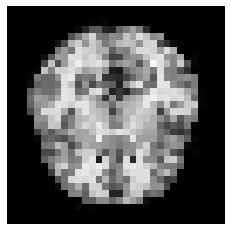

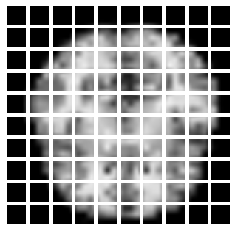

In [19]:
#display a patch
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
# the patch encoding layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=dim )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from torch import nn, einsum
import torch.nn.functional as F


from einops import rearrange, repeat
from einops.layers.torch import Rearrange

In [23]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.dropout = nn.Dropout(dropout)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = dots.softmax(dim=-1)
        attn = self.dropout(attn)

        # re-attention

        attn = einsum('b h i j, h g -> b g i j', attn, self.reattn_weights)
        attn = self.reattn_norm(attn)

        # aggregate and out

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x)
            x = ff(x)
        return x

class DeepViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim,qkv_bias=False, qk_scale=None, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes)  )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [26]:
import torch
import torch.nn as nn
from functools import partial

In [ ]:
def deepvit_instantiator(pretrained=False,**kwargs):
  transformer = [False] * 0 + [True] * 16
  model = DeepViT(num_classes=4,  image_size=32, patch_size=32, dim=256, depth= 8, heads=12, mlp_dim=3,**kwargs)    
  if pretrained:
    load_pretrained(model, num_classes=model.num_classes, in_chans=kwargs.get('in_chans', 3))
  return model

In [28]:
base_model= deepvit_instantiator()

In [29]:
from torchsummary import summary

In [32]:
summary(base_model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Rearrange-1              [-1, 1, 3072]               0
            Linear-2               [-1, 1, 256]         786,688
           Dropout-3               [-1, 2, 256]               0
         LayerNorm-4               [-1, 2, 256]             512
            Linear-5              [-1, 2, 2304]         589,824
           Dropout-6             [-1, 12, 2, 2]               0
         Rearrange-7             [-1, 2, 2, 12]               0
         LayerNorm-8             [-1, 2, 2, 12]              24
         Rearrange-9             [-1, 12, 2, 2]               0
           Linear-10               [-1, 2, 256]         196,864
          Dropout-11               [-1, 2, 256]               0
        Attention-12               [-1, 2, 256]               0
          PreNorm-13               [-1, 2, 256]               0
         Residual-14               [-1,

In [33]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

In [ ]:
criterion= CrossEntropyLoss()
optimizer= optim.Adam(base_model.parameters(),lr=0.001,weight_decay=0.0001)

In [36]:
x_train.shape

(5120, 3, 32, 32)

In [37]:
x_train= np.transpose(x_train,(0,3,1,2))

In [38]:
x_train.shape

(5120, 32, 3, 32)

In [44]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 5.1 MB/s 


In [50]:
from torchmetrics import Accuracy

In [ ]:
n_epochs=20
accuracy= Accuracy()
i=0
for epoch in range(n_epochs):
  running_loss=0.0
  features= torch.from_numpy(x_train)
  labels= torch.from_numpy(y_train)
  optimizer.zero_grad()

  outputs=base_model(features)
  loss=criterion(outputs,labels)
  loss.backward()
  optimizer.step()


  running_loss+=loss.item()
  ouputs= torch.tensor(outputs)
  labels= torch.tensor(labels)

  print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
  print(f'[{epoch+1},{i+1:5d}] accuracy:{accuracy(outputs,labels)}')
  running_loss = 0.0
  i+=1
print('Finished Training')


In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay
    )
    # model.compile(
    #     optimizer=optimizer,
    #     metrics=[
    #         keras.metrics.CategoricalAccuracy(name="accuracy"),
    #         keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    #     ],
    # )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # history = model.fit(
    #     x=x_train,
    #     y=y_train,
    #     batch_size=batch_size,
    #     epochs=num_epochs,
    #     validation_split=0.1,
    #     callbacks=[checkpoint_callback] )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # return history


deepvit_classifier = create_deepvit_classifier()
deep_vit = deepvitf()
history = run_experiment(deep_vit)